In [2]:
import networkx as nx
import pickle

import numpy as np; np.set_printoptions(suppress=True, linewidth=180); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset, plot_twocomponent_results
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph
from analyse_simulation import two_component_statistics

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

In [3]:
model = 'model_0'

In [4]:
G = load_pickled_neuron_graph(f'neuron_graphs/{model}.pkl')

In [10]:
T = 30000

DELTA = 0.25
NSS = 210
for node, data in G.nodes(data = True):
    if data['nodetype'] == 1:
        data['delta'] = DELTA
    data['nss'] = NSS

VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.5, delta=DELTA)
print(START_STATE)
print(START_STATE[0]+DELTA*START_STATE[1])

# get the parameter values for which the simulations will be run
C_B_val = sequence = [round(i * 10**-decimals, 14) for decimals in range(2, 13) for i in range(10, 0, -1)]
C_B_val = [element for i, element in enumerate(C_B_val) if i % 10 == 0] # sparseify for testing
print(f"preparing to simulate {model} with the following parameters:")
print(C_B_val, '\n')

[168, 168, 168, 168]
210.0
preparing to simulate model_0 with the following parameters:
[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11] 




<<<< STARTING SIMULATION WITH C_B = 0.1 >>>>

simulating using gillespie...


100%|██████████| 300/300 [06:12<00:00,  1.24s/it]



Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0
mk trend: increasing p= 0.0214
kpss: stationary p= 0.0686

Eff. pop. size:
wilcox. test: none p= 0.3115
pooled t test: none p= 0.3622
mk trend: no trend p= 0.7513
kpss: stationary p= 0.1

Heteroplasmy:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0
mk trend: increasing p= 0.0
kpss: stationary p= 0.0734

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   672.00     0.0    420.00     0.00    0.5000   0.0000   0.0000   0.0000     0.0     168.00      0.00     168.00      0.00     168.00      0.00     168.00      0.00
100  30000.0  1625.53    14.8    420.08     0.09    0.9567   0.0118   0.9567   0.0433     0.0       9.14      2.48     804.03      9.88       9.12      2.48     803.24      9.87



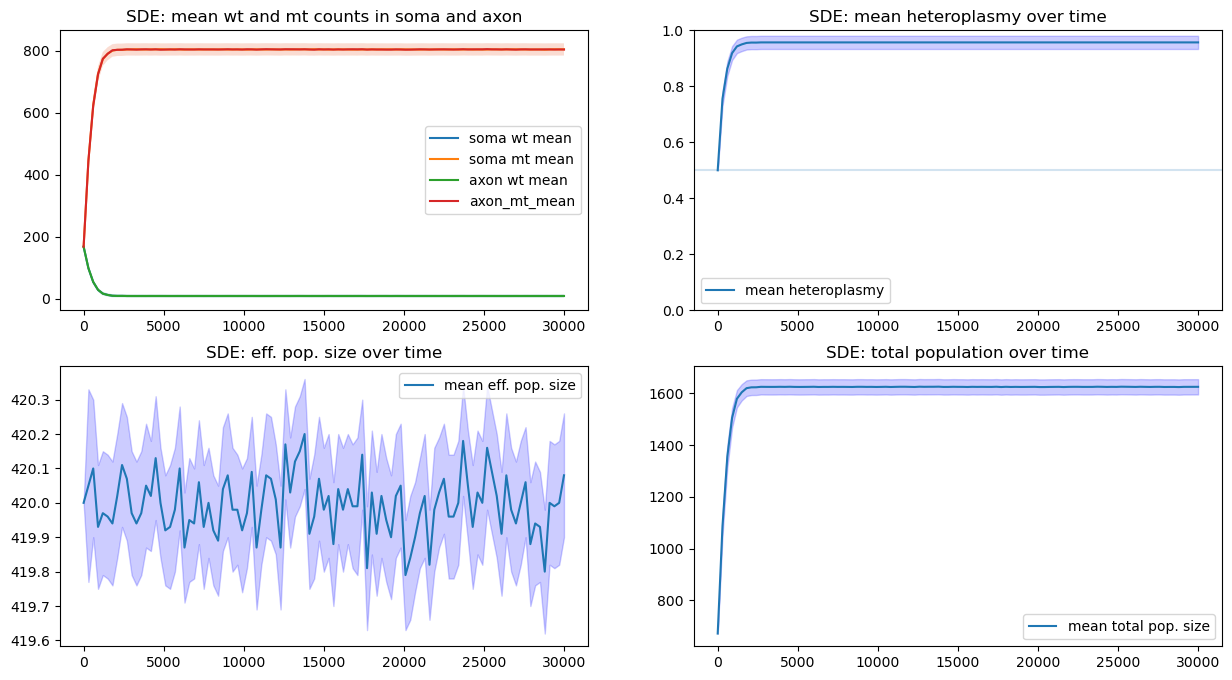

simulating using tau leaping...


 11%|█▏        | 34/300 [00:19<01:55,  2.30it/s]

KeyboardInterrupt: 

 12%|█▏        | 36/300 [00:36<01:54,  2.30it/s]

In [11]:
TIME_POINTS = np.linspace(0, T, 101)
REP = 300

C_B_val = [0.1]

stats_df = pd.DataFrame()

for c_b in C_B_val:
    print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
    for node, data in G.nodes(data = True):
        if data['nodetype'] == 1:
            data['c_b'] = c_b

#     # infer the ode model
#     ode_model = ode_from_network(G, prnt=True)

#     # run the ode model
#     ode_results = simulate_ode(ode_model, TIME_POINTS, START_STATE)
#     plot_ode_results(ode_results, TIME_POINTS, DELTA, VARS, NODES, prnt=False)

    # infer the parameterse of the sde systems
    SDE_PARAM = sde_param_from_network(G, prnt=False)

    # run the gillespie simulation
    gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP)
    df_g, stats_g = two_component_statistics(gillespie_results, TIME_POINTS, DELTA)
    
    stats_g['simtype'] = 'g'
    stats_g['cb'] = c_b
    stats_df = stats_df.append(pd.Series(stats_g), ignore_index=True)
    
    print(df_g.iloc[[0, -1]]);print()
    plot_twocomponent_results(df_g)
    
    
    # run the tau leaping simulation
    tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP, timestep=0.005)
    df_t, stats_t = two_component_statistics(tauleaping_results, TIME_POINTS, DELTA)
    
    stats_t['simtype'] = 't'
    stats_t['cb'] = c_b
    stats_df = stats_df.append(pd.Series(stats_t), ignore_index=True)
    
    print(df_t.iloc[[0, -1]]);print()
    plot_twocomponent_results(df_t)
    
    print("\n ----- \n")
    
print(stats_df)